# Model Performance & Allocation Analysis
    
This notebook visualizes the performance of the 3-model system (Return, Volatility, Market Regime) and the final allocation logic.
It helps identify why penalties (Volatility or Return) might be high.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load Data
project_root = Path.cwd().parent
if str(Path.cwd()).endswith('scripts'): # If running from scripts dir
    project_root = Path.cwd().parent
elif str(Path.cwd()).endswith('notebooks'):
    project_root = Path.cwd().parent

# Load Test Predictions (Last 180 days)
test_path = project_root / 'results' / 'test_predictions.csv'
if not test_path.exists():
    print(f"File not found: {test_path}")
else:
    df = pd.read_csv(test_path)
    print(f"Loaded {len(df)} rows from {test_path}")
    display(df.head())


Loaded 180 rows from /Users/gimjunseog/projects/quant_strategy/results/test_predictions.csv


,date_id,actual_return,pred_return,pred_risk,pred_risk2,allocation
0,8841,0.006791,0.000107,0.009858,0.001524,0.007593
1,8842,0.000761,0.000342,0.009222,0.000150,0.025979
2,8843,-0.003221,0.000332,0.009141,-0.001618,0.000000
3,8844,0.010558,0.000190,0.008925,-0.001162,0.000000
4,8845,-0.000049,-0.000109,0.008059,-0.000663,0.000000


## 1. Return Model Analysis (Model A)
Check if the return predictions (Direction & Magnitude) align with actual returns.
- **IC (Information Coefficient)**: Correlation between Pred and Actual.
- **Scatter Plot**: Pred vs Actual.


Information Coefficient (IC): 0.0252


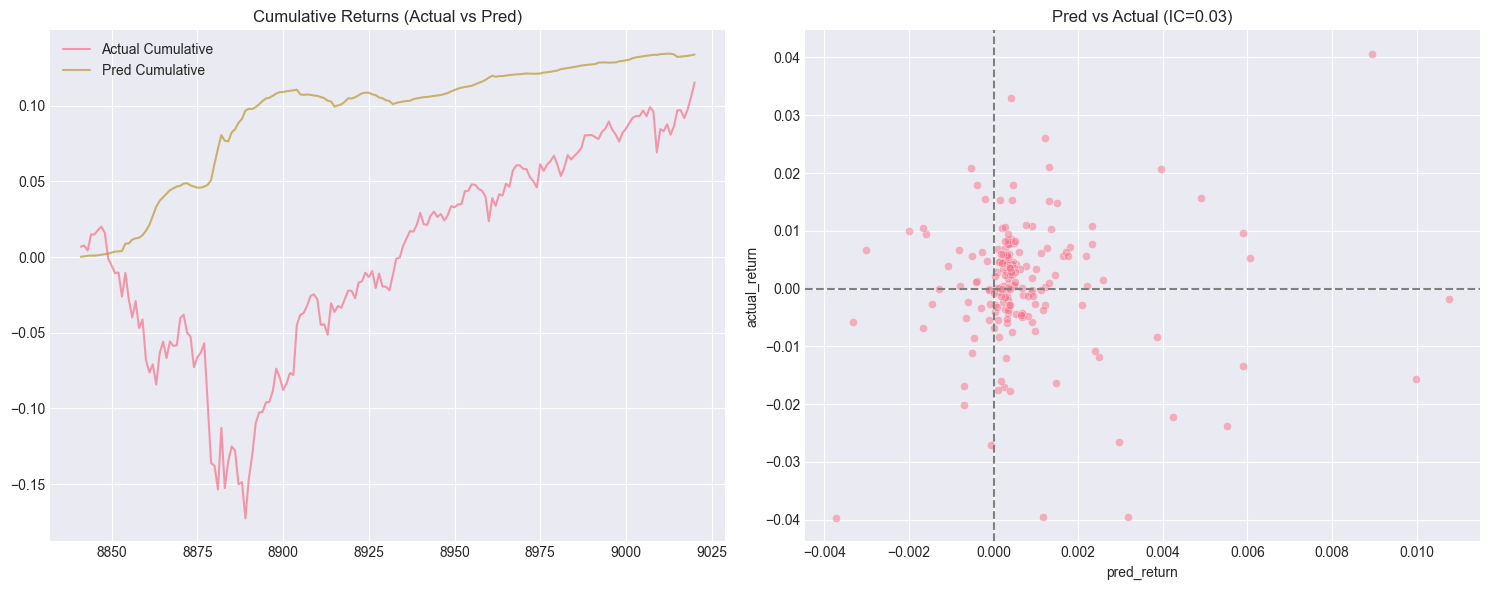

In [2]:
# Metrics
ic = df['pred_return'].corr(df['actual_return'])
print(f"Information Coefficient (IC): {ic:.4f}")

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Time Series
ax[0].plot(df['date_id'], df['actual_return'].cumsum(), label='Actual Cumulative', alpha=0.7)
ax[0].plot(df['date_id'], df['pred_return'].cumsum(), label='Pred Cumulative', alpha=0.7)
ax[0].set_title("Cumulative Returns (Actual vs Pred)")
ax[0].legend()

# Scatter
sns.scatterplot(data=df, x='pred_return', y='actual_return', ax=ax[1], alpha=0.5)
ax[1].set_title(f"Pred vs Actual (IC={ic:.2f})")
ax[1].axhline(0, color='grey', linestyle='--')
ax[1].axvline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()


## 2. Risk Model Analysis (Model B - Volatility)
Check if the risk model correctly predicts high volatility (Absolute Returns).
- **Target**: `abs(actual_return)`
- **Goal**: Predict higher values when actual volatility is high.


Risk Correlation: 0.5269


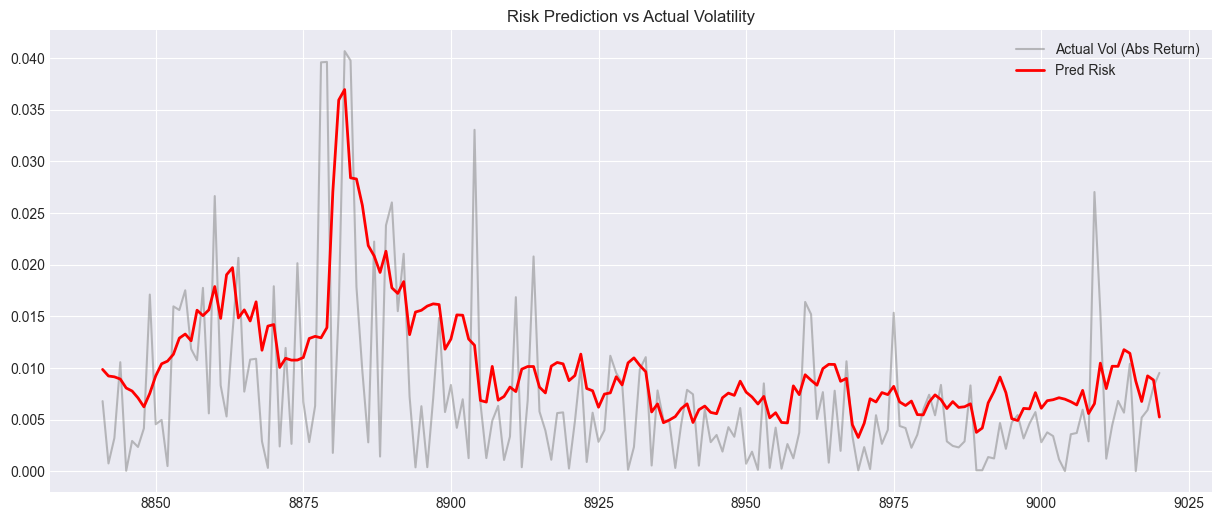

In [3]:
# Metrics
risk_corr = df['pred_risk'].corr(df['actual_return'].abs())
print(f"Risk Correlation: {risk_corr:.4f}")

# Plot
plt.figure(figsize=(15, 6))
plt.plot(df['date_id'], df['actual_return'].abs(), label='Actual Vol (Abs Return)', alpha=0.5, color='grey')
plt.plot(df['date_id'], df['pred_risk'], label='Pred Risk', color='red', linewidth=2)
plt.title("Risk Prediction vs Actual Volatility")
plt.legend()
plt.show()


## 3. Market Regime Analysis (Model C)
Check if the market regime model correctly identifies crashes.
- **Goal**: Predict negative values during market downturns.


Market Model Correlation: 0.2478


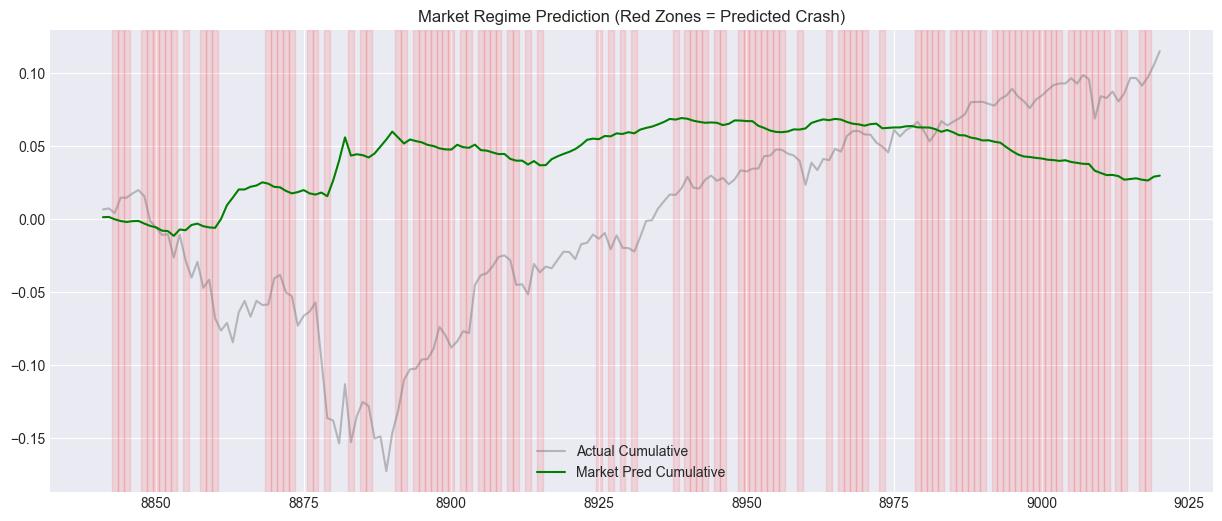

In [4]:
if 'pred_risk2' in df.columns:
    # Metrics
    # Assuming risk2 target was market return (or proxy)
    # We compare with actual return for simplicity (assuming high correlation with market)
    mkt_corr = df['pred_risk2'].corr(df['actual_return'])
    print(f"Market Model Correlation: {mkt_corr:.4f}")

    # Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(df['date_id'], df['actual_return'].cumsum(), label='Actual Cumulative', color='grey', alpha=0.5)
    
    # Color background based on Regime Prediction
    # Red zone if pred_risk2 < 0 (Crash predicted)
    y_min, y_max = ax.get_ylim()
    
    # Find crash zones
    crash_mask = df['pred_risk2'] < 0
    # Simple fill (might be slow for many points, but fine for 180)
    for idx in df[crash_mask].index:
        ax.axvspan(df.loc[idx, 'date_id']-0.5, df.loc[idx, 'date_id']+0.5, color='red', alpha=0.1)
        
    ax.plot(df['date_id'], df['pred_risk2'].cumsum(), label='Market Pred Cumulative', color='green')
    ax.set_title("Market Regime Prediction (Red Zones = Predicted Crash)")
    ax.legend()
    plt.show()
else:
    print("Risk Model 2 predictions not found.")


## 4. Allocation & Penalties
Analyze the final allocation and its impact on penalties.
- **Volatility Penalty**: Triggered if `Strategy Vol / Market Vol > 1.2`.
- **Return Penalty**: Triggered if `Strategy Return < Market Return`.


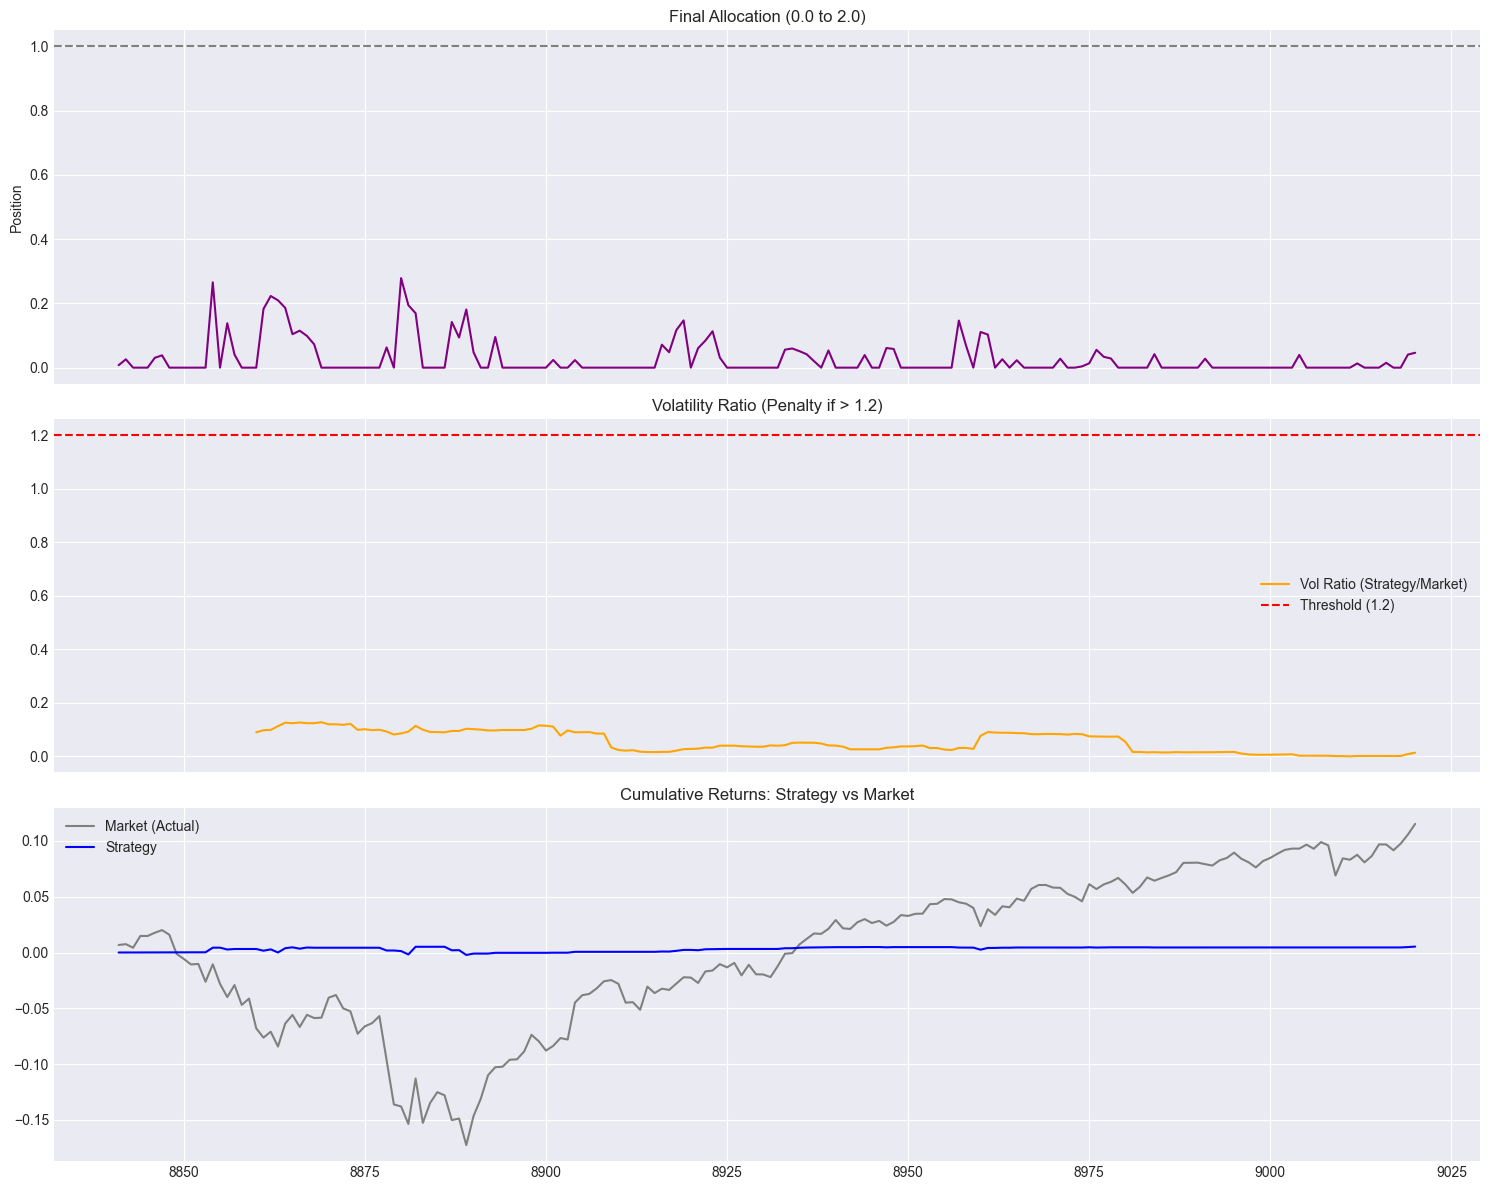

In [5]:
# Calculate Strategy Returns
df['strategy_return'] = df['allocation'] * df['actual_return']

# Rolling Volatility (20 days)
window = 20
df['strategy_vol'] = df['strategy_return'].rolling(window).std() * np.sqrt(252) * 100
df['market_vol'] = df['actual_return'].rolling(window).std() * np.sqrt(252) * 100
df['vol_ratio'] = df['strategy_vol'] / (df['market_vol'] + 1e-6)

# Plot Allocation
fig, ax = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# 1. Allocation
ax[0].plot(df['date_id'], df['allocation'], label='Allocation', color='purple')
ax[0].axhline(1.0, linestyle='--', color='grey')
ax[0].set_title("Final Allocation (0.0 to 2.0)")
ax[0].set_ylabel("Position")

# 2. Volatility Ratio
ax[1].plot(df['date_id'], df['vol_ratio'], label='Vol Ratio (Strategy/Market)', color='orange')
ax[1].axhline(1.2, color='red', linestyle='--', label='Threshold (1.2)')
ax[1].set_title("Volatility Ratio (Penalty if > 1.2)")
ax[1].legend()

# 3. Cumulative Returns
ax[2].plot(df['date_id'], df['actual_return'].cumsum(), label='Market (Actual)', color='grey')
ax[2].plot(df['date_id'], df['strategy_return'].cumsum(), label='Strategy', color='blue')
ax[2].set_title("Cumulative Returns: Strategy vs Market")
ax[2].legend()

plt.tight_layout()
plt.show()
